## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [54]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

# На нашем курсе по аналитике https://karpov.courses/ секцию про bootstrap читают ребята из https://www.experiment-fest.ru/
# Функция get_bootstrap взята из их занятия по АБ тестам

## Функции для вычисления размера эффекта

In [11]:
def cliffsDelta(lst1, lst2, **dull):
    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d #, size                  # Закоментировал возвращение дискретного значения размера эффекта,
                                      # чтобы без проблем использовать bootstrap 

def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'

def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two

## Функция bootstrap

In [160]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    N = 1,
    concat = True,
    plot_flag = False,
    colname = ''
):
    if (concat):
        boot_len_1 = len(data_column_1)
        boot_len_2 = len(data_column_2)
        data_for_sample_1 = pd.Series(np.concatenate((data_column_1, data_column_2), axis=None))
        data_for_sample_2 = pd.Series(np.concatenate((data_column_1, data_column_2), axis=None))
        const = statistic(data_column_1) - statistic(data_column_2)
    else:
        boot_len_1 = max([len(data_column_1), len(data_column_2)])
        boot_len_2 = max([len(data_column_1), len(data_column_2)])
        data_for_sample_1 = data_column_1
        data_for_sample_2 = data_column_2
        const = 0
        
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_for_sample_1.sample(
            boot_len_1, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_for_sample_2.sample(
            boot_len_2,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2)) 
    
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    quants.columns = [str(statistic.__name__)]
    
    if (concat):
        p_value = norm.cdf(x = -np.abs(const), loc = np.mean(boot_data), scale = np.std(boot_data)) * 2
    else:
        p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
        p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
        p_value = min(p_1, p_2) * 2
    
    if p_value > 1:
        p_value = 1
        
    # Визуализация
    
    if(plot_flag):
        sns.displot(x = pd_boot_data[0], kind = "kde", fill = True)
        plt.vlines(const, ymin=0, ymax=50, linestyle='-', color='black')
        plt.vlines(quants, ymin=0, ymax=50, linestyle='--', color='green')
        plt.xlabel('Разность ' + str(statistic.__name__) + ' двух групп')
        plt.title("Histogram of " + colname)
        plt.show()
        
    '''
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0] or bar.get_x() < 0:
            bar.set_facecolor('red')
            bar.set_edgecolor('black')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    #r = abs(statistic(data_column_1) - statistic(data_column_2))
    #plt.axvline(r,ymin=0,ymax=50,linestyle=':')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of " + colname)
    plt.show()
    '''
    if (const >= quants.iloc[:, 0].iloc[0]) & (const <= quants.iloc[:, 0].iloc[1]):
        result = False
    else:
        if (p_value >= 0.01 / N):
            result = False
        else:
            result = True
            
    observed_difference = statistic(data_column_1) - statistic(data_column_2)
       
    return {"result": result,
            "observed_difference": observed_difference,
            "quants": quants,
            "p_value": p_value}

## Загрузка данных

In [110]:
data = pd.read_csv('C:/Disk_for_Data_Science/MazalTovGeksli/Projects/MMA/data/all_data.csv', sep=',')
data = data.drop(['brow_a', 'brow_b', 'brow_c', 'brow_d'], axis=1)

In [111]:
data_norm = data.copy()
for col in tqdm(data.columns[:-1]):
    data_norm[col] = (data_norm[col] - data_norm[col].quantile(0.001)) / (data_norm[col].quantile(0.999) - data_norm[col].quantile(0.001))

In [112]:
data_norm.shape

(3188, 20)

In [134]:
col = data_norm.columns[:19]

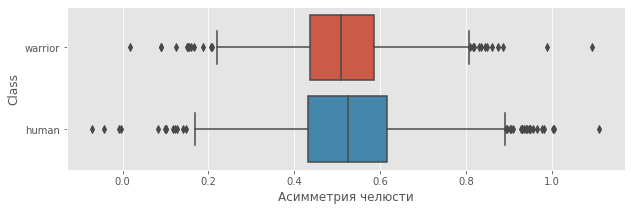

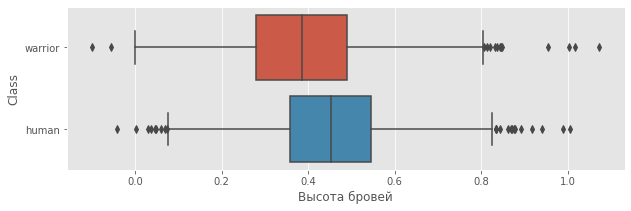

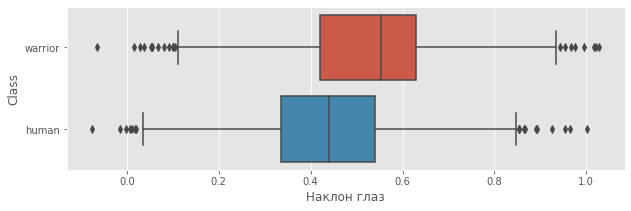

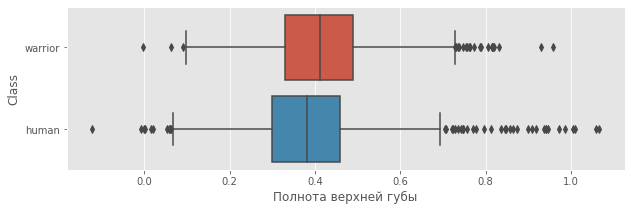

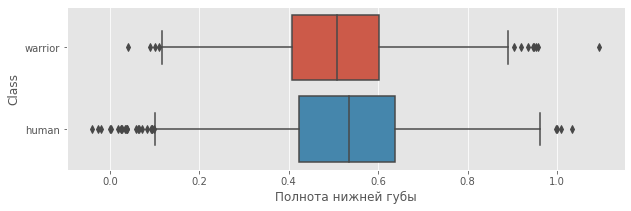

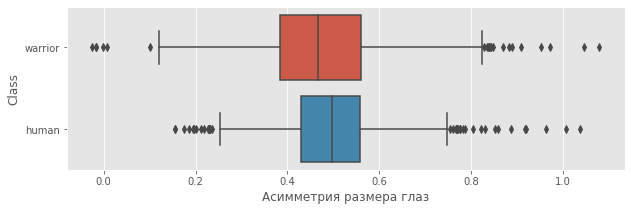

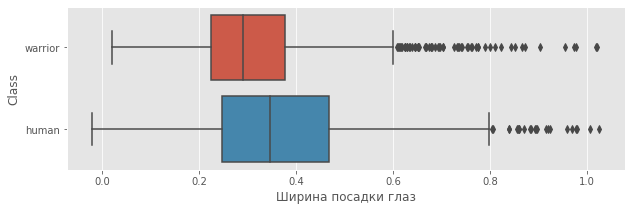

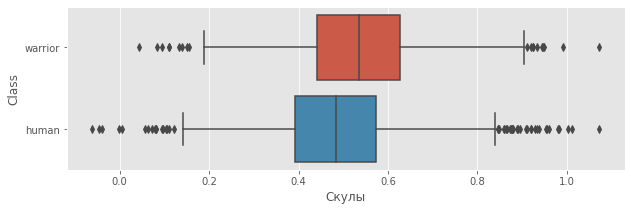

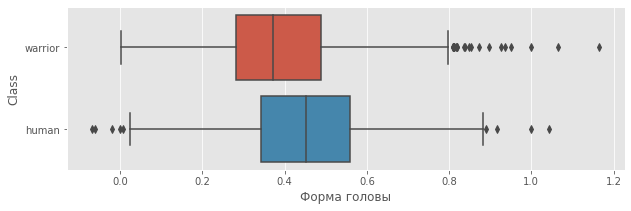

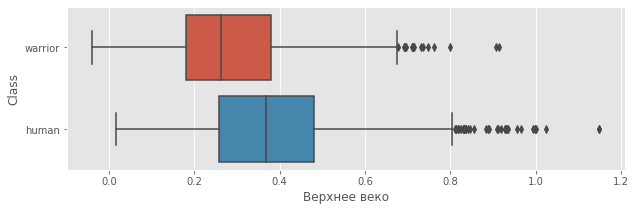

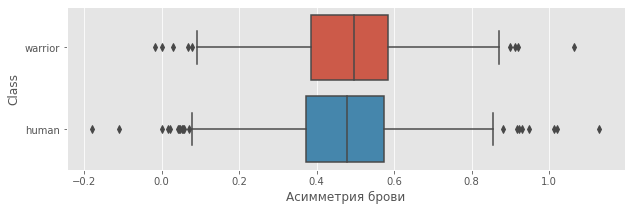

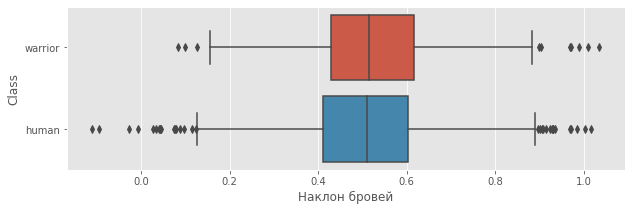

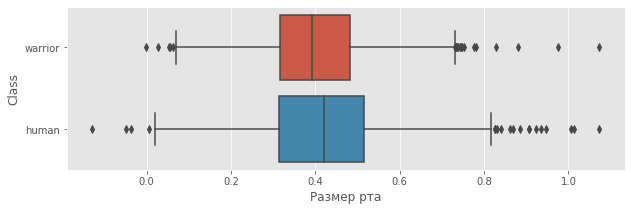

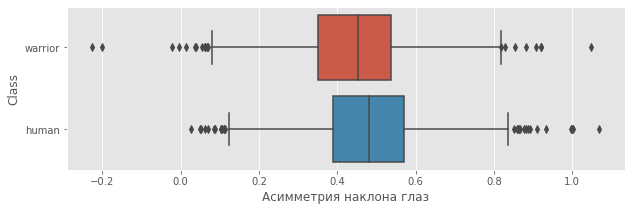

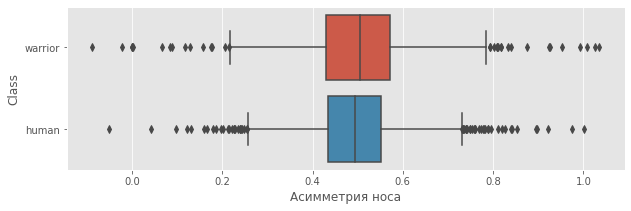

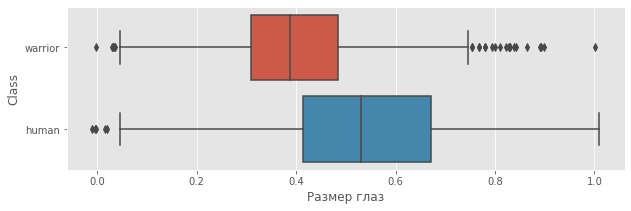

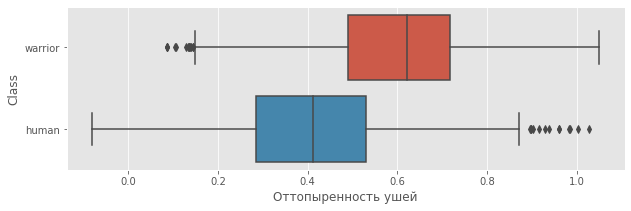

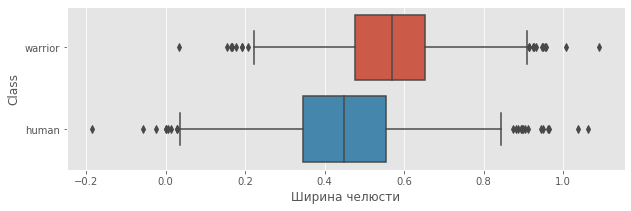

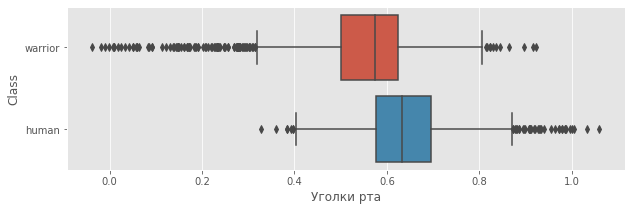

In [114]:
for i in data_norm.columns[0:19]:
    f, ax = plt.subplots(figsize=(10, 3))
    sns.boxplot(data=data_norm, x=i, y="Class")
    plt.show()

In [175]:
war = data_norm[data_norm.Class == 'warrior']
hum = data_norm[data_norm.Class == 'human']

## Объединяем выборки и извлекаем из общей 2 подвыборки каждая исходного размера и смотрим разность статистики

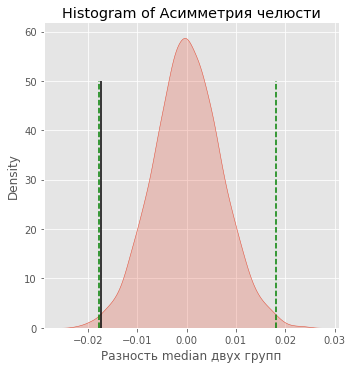

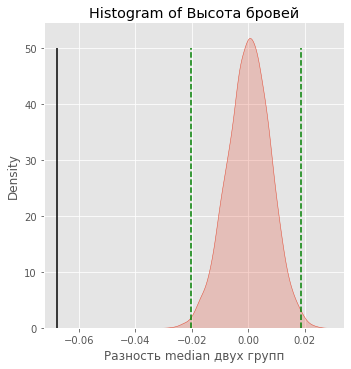

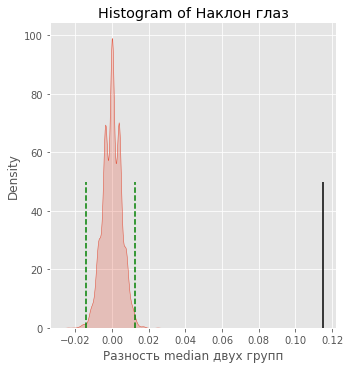

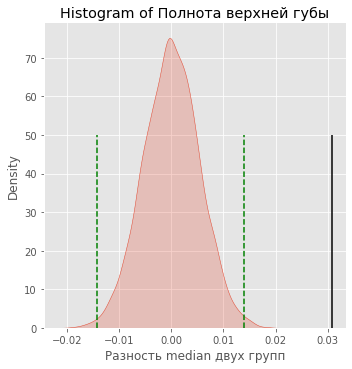

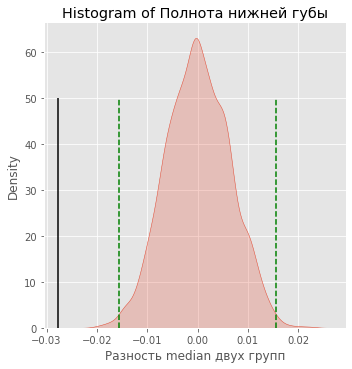

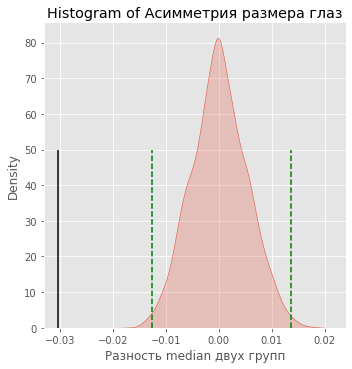

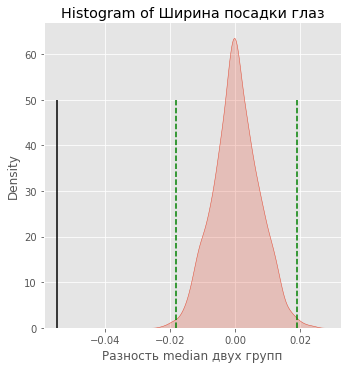

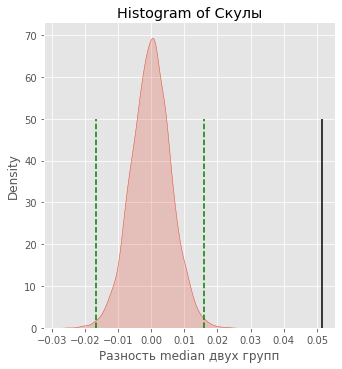

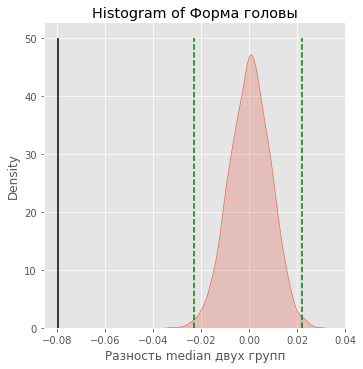

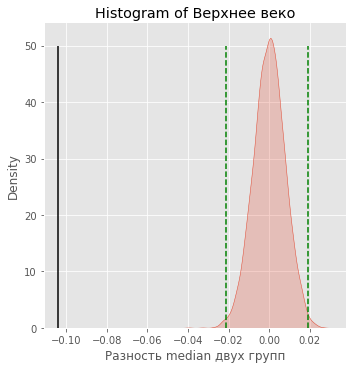

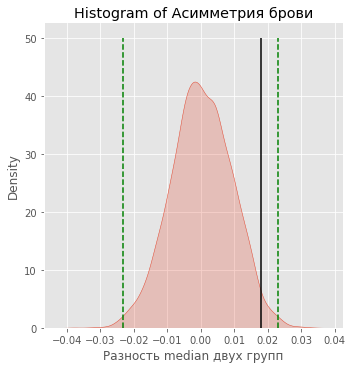

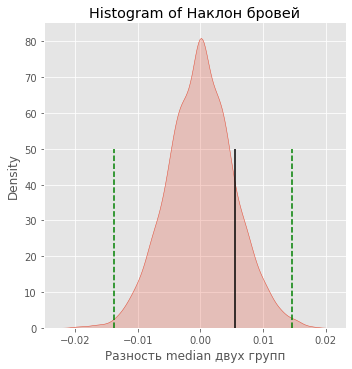

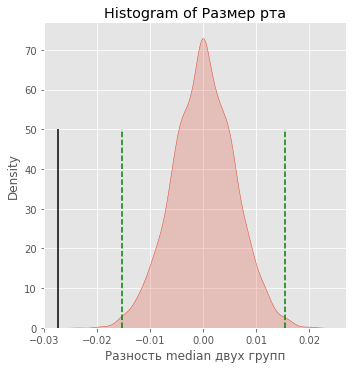

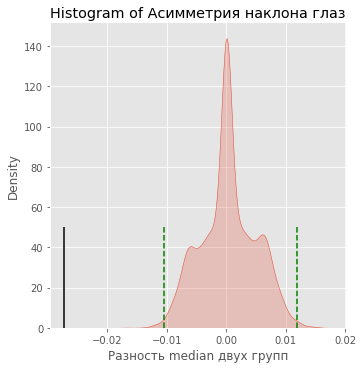

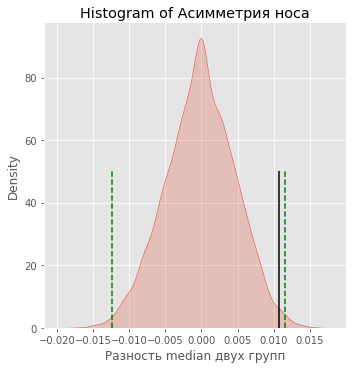

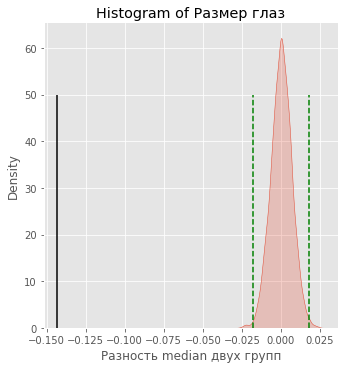

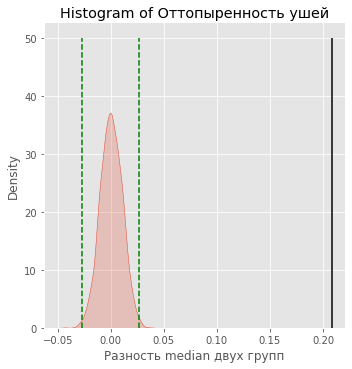

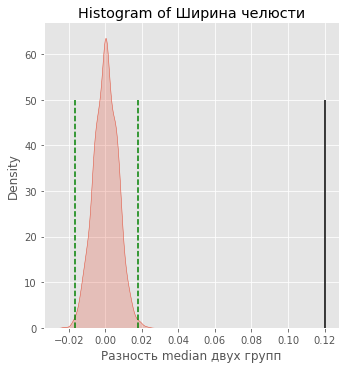

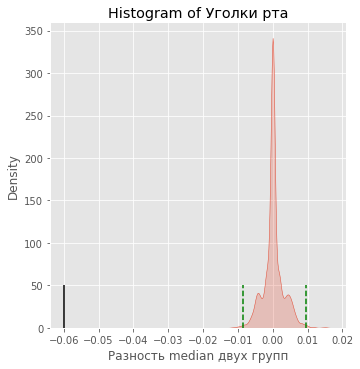

In [176]:
l_bot_quant = []
l_top_quant = []
l_observed_difference = []
l_p_value = []
l_result = []

s = np.median
n = 19 # Поправка на множественное сравнение (количество проверяемых гипотез)
for i in data.columns[0:19]:
    res = get_bootstrap(
        war[i], # числовые значения первой выборки
        hum[i], # числовые значения второй выборки
        boot_it = 5000, # количество бутстрэп-подвыборок
        statistic = s, # интересующая нас статистика
        bootstrap_conf_level = 0.99,
        N = n,
        concat = True,
        plot_flag = True,
        colname = i)
    
    l_observed_difference.append(res['observed_difference'])
    l_p_value.append(res['p_value'])
    l_result.append(res['result'])
    l_bot_quant.append(res['quants'].iloc[:, 0].iloc[0])
    l_top_quant.append(res['quants'].iloc[:, 0].iloc[1])

In [177]:
res_boostrap = pd.DataFrame([col, l_observed_difference, l_bot_quant, l_top_quant, l_p_value, l_result])
res_boostrap = res_boostrap.T
res_boostrap.columns = ['Feature', 'Наблюдаемая разница ' + str(s.__name__), 
                        'Нижняя граница доверительного интервала', 
                        'Верхняя граница доверительного интервала', 'p_value', 'Значимость']
res_boostrap.sort_values(by='p_value', ascending=False)

,Feature,Наблюдаемая разница median,Нижняя граница доверительного интервала,Верхняя граница доверительного интервала,p_value,Значимость
11,Наклон бровей,0.0054421,-0.0138492,0.0146807,0.306736,False
10,Асимметрия брови,0.0180058,-0.0232429,0.0229602,0.0472631,False
14,Асимметрия носа,0.0106736,-0.0123963,0.0116097,0.0276636,False
0,Асимметрия челюсти,-0.0173396,-0.0176724,0.0181609,0.0116201,False
4,Полнота нижней губы,-0.0278157,-0.0155862,0.015648,1.00846e-05,True
12,Размер рта,-0.0274603,-0.0153408,0.0155284,2.78118e-06,True
3,Полнота верхней губы,0.0308085,-0.0142388,0.0139776,1.02998e-08,True
5,Асимметрия размера глаз,-0.0304326,-0.0126646,0.0135762,7.33666e-09,True
13,Асимметрия наклона глаз,-0.0273582,-0.0104504,0.0119309,2.03643e-09,True
6,Ширина посадки глаз,-0.0548055,-0.0183015,0.0191949,1.52268e-14,True


## из каждой выборки извлекаем max(len(x), len(y)) и смотрим разницу в статистике

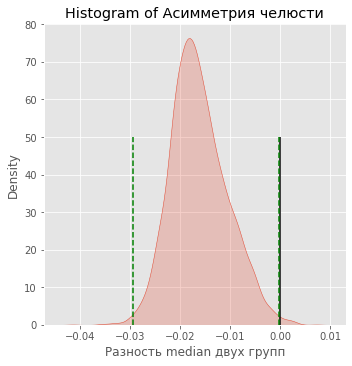

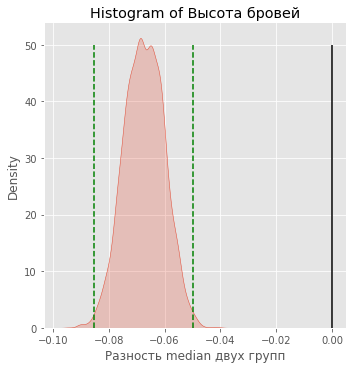

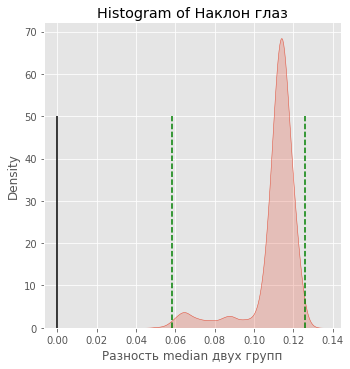

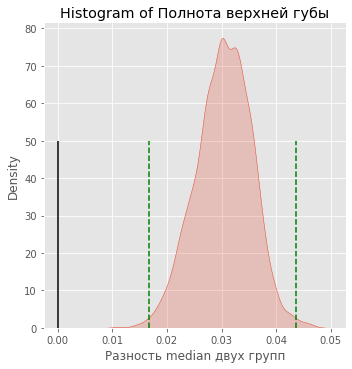

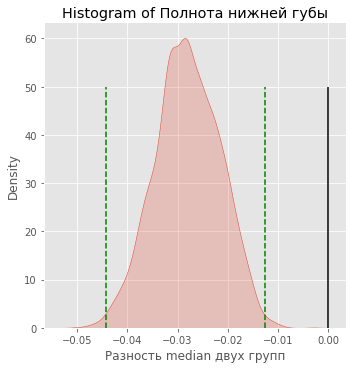

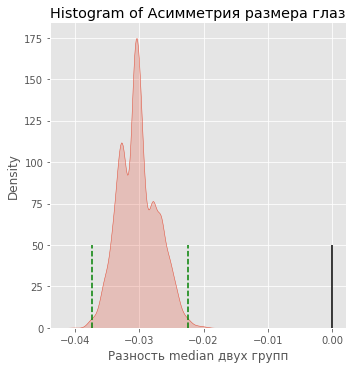

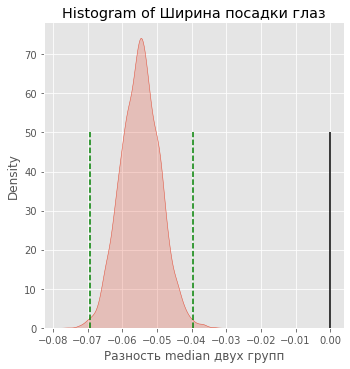

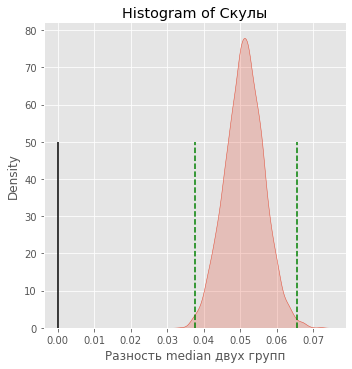

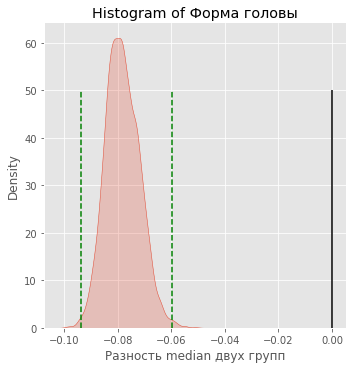

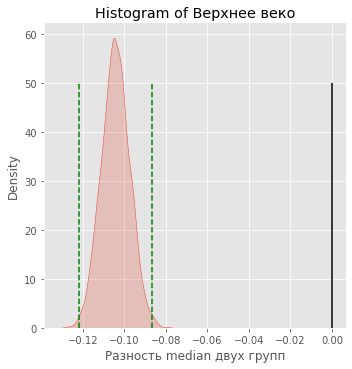

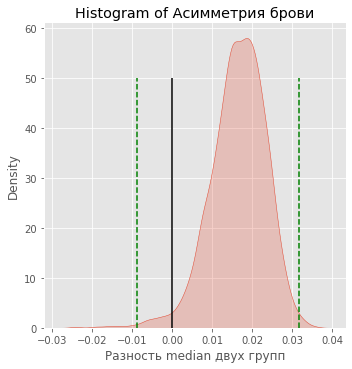

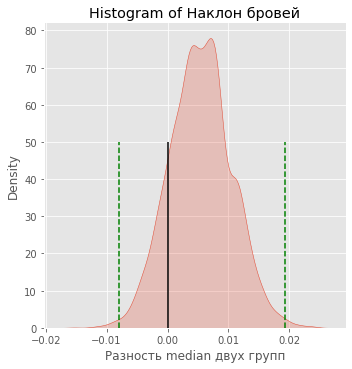

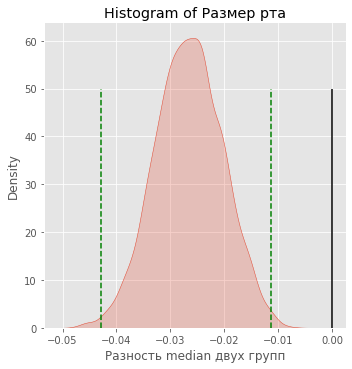

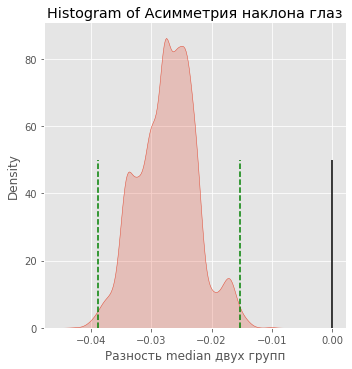

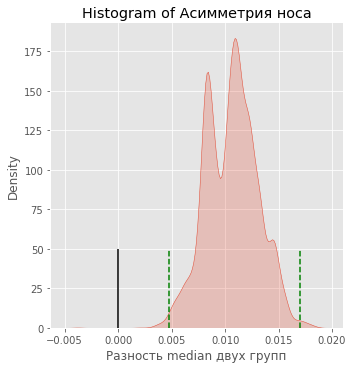

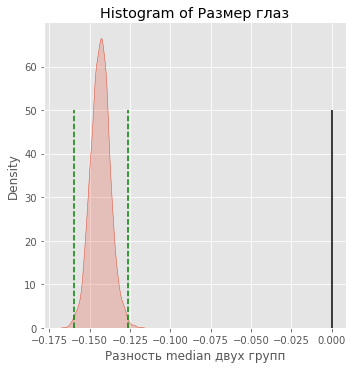

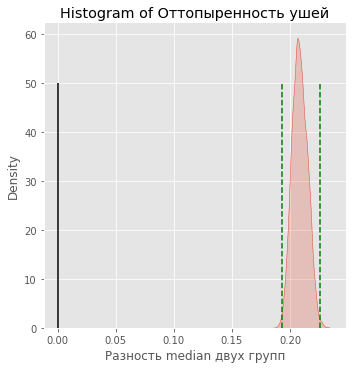

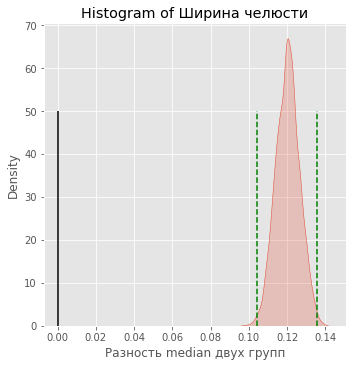

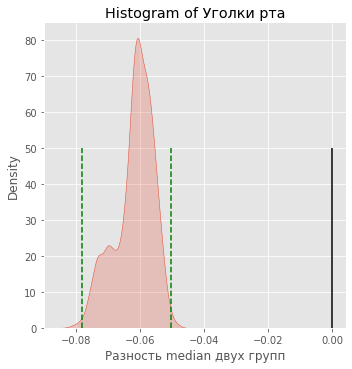

In [178]:
l_bot_quant = []
l_top_quant = []
l_observed_difference = []
l_p_value = []
l_result = []

s = np.median
n = 19 # Поправка на множественное сравнение (количество проверяемых гипотез)
for i in data.columns[0:19]:
    res = get_bootstrap(
        war[i], # числовые значения первой выборки
        hum[i], # числовые значения второй выборки
        boot_it = 5000, # количество бутстрэп-подвыборок
        statistic = s, # интересующая нас статистика
        bootstrap_conf_level = 0.99,
        N = n,
        concat = False,
        plot_flag = True,
        colname = i)
    
    l_observed_difference.append(0)
    l_p_value.append(res['p_value'])
    l_result.append(res['result'])
    l_bot_quant.append(res['quants'].iloc[:, 0].iloc[0])
    l_top_quant.append(res['quants'].iloc[:, 0].iloc[1])

In [179]:
res_boostrap = pd.DataFrame([col, l_observed_difference, l_bot_quant, l_top_quant, l_p_value, l_result])
res_boostrap = res_boostrap.T
res_boostrap.columns = ['Feature', 'Ожидаемая разница ' + str(s.__name__), 
                        'Нижняя граница доверительного интервала', 
                        'Верхняя граница доверительного интервала', 'p_value', 'Значимость']
res_boostrap.sort_values(by='p_value', ascending=False)

,Feature,Ожидаемая разница median,Нижняя граница доверительного интервала,Верхняя граница доверительного интервала,p_value,Значимость
11,Наклон бровей,0,-0.00789183,0.0192073,0.293928,False
10,Асимметрия брови,0,-0.00878497,0.0315776,0.0200621,False
0,Асимметрия челюсти,0,-0.0293897,-0.000141954,0.00405031,False
12,Размер рта,0,-0.0429624,-0.0112134,2.27463e-05,True
4,Полнота нижней губы,0,-0.0441645,-0.012564,1.36451e-05,True
14,Асимметрия носа,0,0.00475409,0.017006,1.18199e-05,True
13,Асимметрия наклона глаз,0,-0.0389284,-0.0152348,1.0131e-08,True
3,Полнота верхней губы,0,0.0167815,0.0436808,2.37898e-09,True
2,Наклон глаз,0,0.0584283,0.126069,4.96515e-17,True
1,Высота бровей,0,-0.085319,-0.0499283,5.03258e-21,True
